In [1]:
# Only run this block on Google CoLab
# !git clone https://github.com/Holstrup/Mask_RCNN 
# import os
# os.chdir("Mask_RCNN/samples/wireframe")

Using TensorFlow backend.


In [1]:
import os
import sys
import random
import numpy as np
import matplotlib.patches as patches
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
import mrcnn.model as modellib
from mrcnn.model import log
from samples.wireframe.WireframeGenerator import generate_data_3
import samples.wireframe.plots as plots
from samples.wireframe import Wireframe
import samples.wireframe.database_actions as db
from mpl_toolkits.mplot3d import Axes3D
# import samples.wireframe.metrics as metrics
import samples.wireframe.knn as knn
from sklearn.utils.extmath import softmax
import matplotlib.pyplot as plt
import sklearn.decomposition as sk_decomp
from database_actions import add_encoding, reinitialize_table
from knn import overlaps_bool
from model_triplet import Model

%matplotlib inline 

Using TensorFlow backend.


## Detect

In [2]:
NUM_TRAINING_IMAGES = 300
MAX_ICONS_PER_IMAGE = 1

In [3]:
config = Wireframe.WireframeConfig()
WIREFRAME_DIR = os.path.join(ROOT_DIR, "datasets/wireframe")

# Training dataset
dataset_train = Wireframe.WireframeDataset()
dataset_train.generate_data(NUM_TRAINING_IMAGES, MAX_ICONS_PER_IMAGE)
dataset_train.load_wireframe(WIREFRAME_DIR, "train")
dataset_train.prepare()

# Validation dataset
dataset_val = Wireframe.WireframeDataset()
dataset_val.load_wireframe(WIREFRAME_DIR, "val")
dataset_val.prepare()                   

In [4]:
dataset_train.class_info

[{'source': '', 'id': 0, 'name': 'BG'},
 {'source': 'wireframe', 'id': 1, 'name': 'A'},
 {'source': 'wireframe', 'id': 2, 'name': 'Cross'},
 {'source': 'wireframe', 'id': 3, 'name': 'D'},
 {'source': 'wireframe', 'id': 4, 'name': 'Done'},
 {'source': 'wireframe', 'id': 5, 'name': 'H'},
 {'source': 'wireframe', 'id': 6, 'name': 'Heart'},
 {'source': 'wireframe', 'id': 7, 'name': 'Home'},
 {'source': 'wireframe', 'id': 8, 'name': 'I'},
 {'source': 'wireframe', 'id': 9, 'name': 'Menu'},
 {'source': 'wireframe', 'id': 10, 'name': 'More'},
 {'source': 'wireframe', 'id': 11, 'name': 'R'},
 {'source': 'wireframe', 'id': 12, 'name': 'Search'},
 {'source': 'wireframe', 'id': 13, 'name': 'U'},
 {'source': 'wireframe', 'id': 14, 'name': 'Wifi'},
 {'source': 'wireframe', 'id': 15, 'name': 'Z'}]

In [5]:
config.DETECTION_MIN_CONFIDENCE = 0.7

In [4]:
MODEL_FILE_NAME = "Mask_Res50.h5"
class InferenceConfig(Wireframe.WireframeConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# MODEL_FILE_NAME = model.get_pretrained_weights("Mask_Res50.h5")

# Get path to saved weights
model_path = os.path.join(ROOT_DIR, MODEL_FILE_NAME)

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Loading weights from  /Users/alexanderholstrup/git/Mask_RCNN/Mask_Res50.h5


original_image           shape: (512, 512, 3)         min:    0.00000  max:  233.00000  uint8
image_meta               shape: (28,)                 min:    0.00000  max: 1200.00000  float64
gt_class_id              shape: (1,)                  min:   13.00000  max:   13.00000  int64
gt_bbox                  shape: (1, 4)                min:   19.00000  max:  319.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool


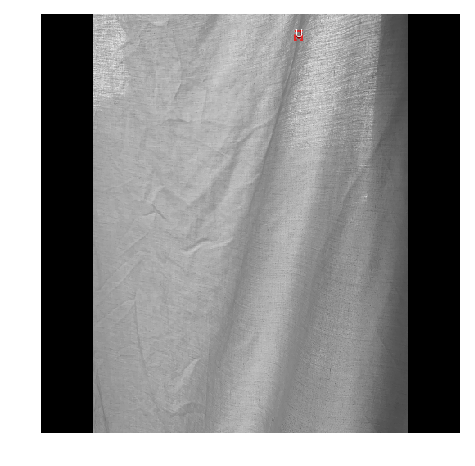

In [7]:
# Test on a random image
image_id = random.choice(dataset_train.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_train, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [8]:
results = model.detect([original_image])

In [9]:
labels = []
for pred in results[0]["class_ids"]:
    labels.append(dataset_train.class_info[pred]["name"])

In [10]:
print("Real: {}".format(gt_class_id))
print("Predicted: {}".format(results[0]["class_ids"]))
print(results[0]["scores"])
print(labels)

Real: [13]
Predicted: [4]
[0.7034439]
['Done']


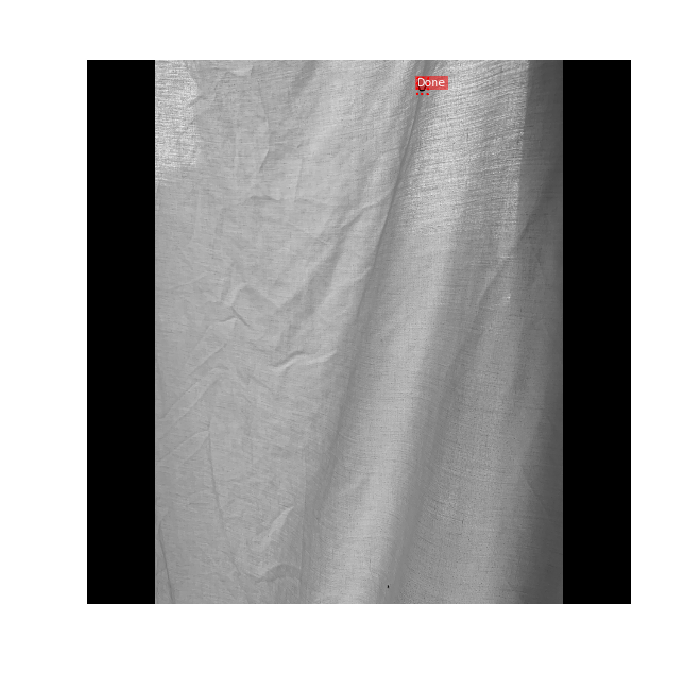

In [11]:
visualize.draw_boxes(original_image, results[0]['rois'], captions = labels)

## Confusion matrix

In [9]:
true = []
prediction = []

for i in dataset_train.image_ids:
    if i % 10 == 0: print(i)
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_train, inference_config, 
                               i, use_mini_mask=False)
    results = model.detect([original_image]) 
    
    
    if (len(results[0]["class_ids"]) >= 1):
        pred_label = dataset_train.class_info[results[0]["class_ids"][0]]["name"]
        prediction.append(pred_label)
    elif (len(results[0]["class_ids"]) == 0):
          continue
    
    trueList = np.array(gt_class_id).tolist()
    true_label = dataset_train.class_info[trueList[0]]["name"]
    
    true.append(true_label)
    trueList = np.array(true).tolist()
    trueFlattened = [val for sublist in trueList for val in sublist]

    
confusion_matrix = plots.plot_confusion_matrix(trueFlattened, prediction, normalize=False)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3291, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-158025c53fab>", line 8, in <module>
    results = model.detect([original_image])
  File "/Users/alexanderholstrup/git/Mask_RCNN/mrcnn/model.py", line 2548, in detect
    self.keras_model.predict([molded_images, image_metas, anchors], verbose=0)
  File "/usr/local/lib/python3.7/site-packages/keras/engine/training.py", line 1169, in predict
    steps=steps)
  File "/usr/local/lib/python3.7/site-packages/keras/engine/training_arrays.py", line 294, in predict_loop
    batch_outs = f(ins_batch)
  File "/usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py", line 2715, in __call__
    return self._call(inputs)
  File "/usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py", line 2675, in _call
    fetched = self._callable_fn(*array_vals

KeyboardInterrupt: 

## Train

In [ ]:
config = Wireframe.WireframeConfig()
WIREFRAME_DIR = os.path.join(ROOT_DIR, "datasets/wireframe")

In [ ]:
NUM_TRAINING_IMAGES = 100
MAX_ICONS_PER_IMAGE = 3
#generate_data(NUM_TRAINING_IMAGES, MAX_ICONS_PER_IMAGE) 

# Training dataset
dataset_train = Wireframe.WireframeDataset()
dataset_train.load_wireframe(WIREFRAME_DIR, "train")
dataset_train.prepare()

# Validation dataset
dataset_val = Wireframe.WireframeDataset()
dataset_val.load_wireframe(WIREFRAME_DIR, "val")
dataset_val.prepare()

In [ ]:
dataset = Wireframe.WireframeDataset()
dataset.load_wireframe(WIREFRAME_DIR, "train")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset_train.image_ids)))
print("Class Count: {}".format(dataset_train.num_classes))
for i, info in enumerate(dataset_train.class_info):
    print("{:3}. {:50}".format(i, info['name']))

In [ ]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
    
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)